<a href="https://colab.research.google.com/github/9645258/aiffel/blob/main/02_goingdeeper/01_nlp/%5BGD-04%5Dnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GD NLP 04 : 뉴스 카테고리 다중분류**

- **Vocabulary Size를 변경해서 시도해보기**  


- **분류 모델의 accuracy가 기준 이상 높게 나왔는가?**    
    3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.  
    

- **분류 모델의 F1 score가 기준 이상 높게 나왔는가?**    
Vocabulary Size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.  
    
    
- **딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?**    
동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.  

---

## **1. 데이터 준비**

### **1-1. 라이브러리 Import**

In [ ]:
import warnings
warnings.filterwarnings(action = 'ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### **1-2. 데이터 Import**

- **다양한 비교를 위해 5개의 num_word로 분류 (전체 / 10,000 / 5,000 / 3,000 / 1,000)**  
전체의 80%를 훈련 데이터, 20%를 테스트 데이터로 사용  

In [ ]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words = None, test_split = 0.2)
(x_train_1M, y_train_1M), (x_test_1M, y_test_1M) = reuters.load_data(num_words = 10000, test_split = 0.2)
(x_train_5T, y_train_5T), (x_test_5T, y_test_5T) = reuters.load_data(num_words = 5000, test_split = 0.2)
(x_train_3T, y_train_3T), (x_test_3T, y_test_3T) = reuters.load_data(num_words = 3000, test_split = 0.2)
(x_train_1T, y_train_1T), (x_test_1T, y_test_1T) = reuters.load_data(num_words = 1000, test_split = 0.2)

### **1-3. 클래스 확인**

- **레이블 수 확인**    
정수 형태의 레이블

In [ ]:
print(y_train[0])
print(y_test[0])

3
3


- **전체 클래스 수 확인**

In [ ]:
num_classes = max(y_train) + 1
print('전체 클래스 수: {}'.format(num_classes))

전체 클래스 수: 46


- **클래스 분포 확인**     
3,4의 분포가 월등히 많고, 1, 11, 16, 19번의 분포가 약 400개 이상의 분포를 보임

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts = True)

for index, value in enumerate(counts_elements):
    print(f'({index}){value}', end = ', ')

(0)55, (1)432, (2)74, (3)3159, (4)1949, (5)17, (6)48, (7)16, (8)139, (9)101, (10)124, (11)390, (12)49, (13)172, (14)26, (15)20, (16)444, (17)39, (18)66, (19)549, (20)269, (21)100, (22)15, (23)41, (24)62, (25)92, (26)24, (27)15, (28)48, (29)19, (30)45, (31)39, (32)32, (33)11, (34)50, (35)10, (36)49, (37)19, (38)19, (39)24, (40)36, (41)30, (42)13, (43)21, (44)12, (45)18, 

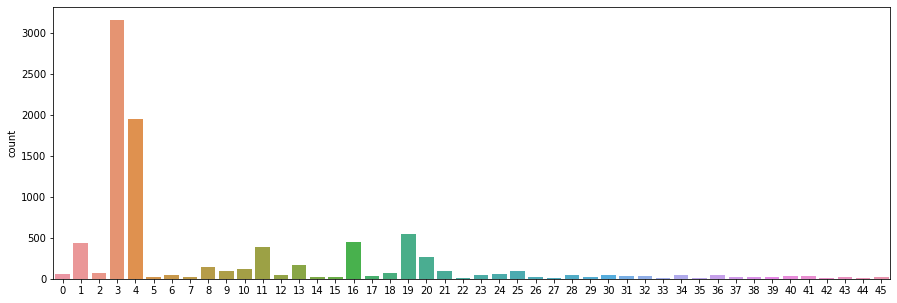

In [ ]:
fig, axe = plt.subplots(ncols = 1)
fig.set_size_inches(15,5)
sns.countplot(x = y_train)
plt.show()

### **1-4. 데이터 확인**

- **데이터 수 확인**  

In [ ]:
print('전체 데이터 수: {}'.format(len(x_train) + len(x_test)))
print('train 데이터 수: {}'.format(len(x_train)))
print('test 데이터 수: {}'.format(len(x_test)))

전체 데이터 수: 11228
train 데이터 수: 8982
test 데이터 수: 2246


- **데이터 길이 분포 확인**  

train 데이터 최소 길이:13
train 데이터 최대 길이:2376
train 데이터 평균 길이:145.5398574927633


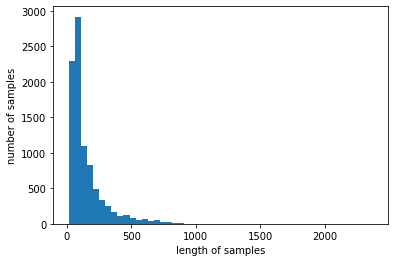

In [ ]:
print('train 데이터 최소 길이:{}'.format(min(len(l) for l in x_train)))
print('train 데이터 최대 길이:{}'.format(max(len(l) for l in x_train)))
print('train 데이터 평균 길이:{}'.format(sum(map(len, x_train)) / len(x_train)))

plt.hist([len(s) for s in x_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

test 데이터 최소 길이:2
test 데이터 최대 길이:1032
test 데이터 평균 길이:147.66117542297417


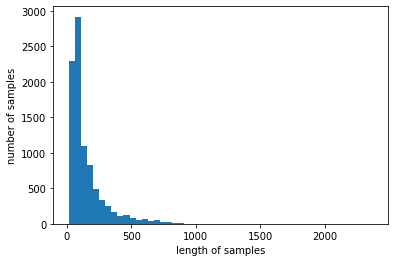

In [ ]:
print('test 데이터 최소 길이:{}'.format(min(len(l) for l in x_test)))
print('test 데이터 최대 길이:{}'.format(max(len(l) for l in x_test)))
print('test 데이터 평균 길이:{}'.format(sum(map(len, x_test)) / len(x_test)))

plt.hist([len(s) for s in x_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### **1-5. 데이터 변환**

- **데이터 형태 확인**  
기본적으로 빈도수가 높은 순서대로 낮은 정수가 맵핑된 전처리 데이터 제공

In [ ]:
print(x_train[0])
print(x_test[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 23406, 28185, 5, 192,

- **텍스트 데이터 변환**  
정수 시퀀스로 변환된 데이터 텍스트 데이터로 변환

In [ ]:
word_index = reuters.get_word_index(path = "reuters_word_index.json")

- **단어 맵핑**  
맵핑 단어는 정수 -3을 입력해 놓은 값 / 고유 숫자의 경우 단어 + 3로 변환 필요

In [ ]:
word_index['the']

1

In [ ]:
index_to_word = { index + 3 : word for word, index in word_index.items() }

In [ ]:
print(index_to_word[4])

the


- **토큰 번호 맵핑**  
로이터 뉴스 데이터는 0-2번을 자연어 처리를 위한 토큰을 위해 번호 맵핑 필요  
0: `<pad>`, 1: `<sos>`, 2: `<unk>`

In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index] = token

- **단어 맵핑 처리**  
이미 전처리가 어느정도 진행되었기 때문에 문맥이 자연스럽지 않음   
맵핑이 진행되지 않은 경우에는 `<unk>`로 출력 (num_words 수가 적어질수록 `<unk>`의 수 증가)

In [ ]:
def mapping_text(data):
    decoded = []
    for i in range(len(data)):
        t = ' '.join([index_to_word[index] for index in data[i]])
        decoded.append(t)
    return decoded

In [ ]:
x_train, x_test = mapping_text(x_train), mapping_text(x_test)
x_train_1M, x_test_1M = mapping_text(x_train_1M), mapping_text(x_test_1M)
x_train_5T, x_test_5T = mapping_text(x_train_5T), mapping_text(x_test_5T)
x_train_3T, x_test_3T = mapping_text(x_train_3T), mapping_text(x_test_3T) 
x_train_1T, x_test_1T = mapping_text(x_train_1T), mapping_text(x_test_1T)

In [ ]:
def mapping_text_print(train, test):
    print('\n', train)
    print('\n', test)
    print('-' * 138)

In [ ]:
print('<전체 num_words 사용>')
mapping_text_print(x_train[0], x_test[0])

print('<10,000개의 num_words 사용>')
mapping_text_print(x_train_1M[0], x_test_1M[0])

print('<5,000개의 num_words 사용>')
mapping_text_print(x_train_5T[0], x_test_5T[0])

print('<3,000개의 num_words 사용>')
mapping_text_print(x_train_3T[0], x_test_3T[0])

print('<1,000개의 num_words 사용>')
mapping_text_print(x_train_1T[0], x_test_1T[0])

<전체 num_words 사용>

 <sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3

 <sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave

### **1-6. 벡터화**

- **DTM / TF-IDF Matrix**  

In [ ]:
dtm_vector = CountVectorizer()
tfidf_vector = TfidfTransformer()

def vector(train, test):
    dtm_x_train = dtm_vector.fit_transform(train)
    tfidf_x_train = tfidf_vector.fit_transform(dtm_x_train)
    
    dtm_x_test = dtm_vector.transform(test)
    tfidf_x_test = tfidf_vector.transform(dtm_x_test)
    
    print('\n', tfidf_x_train.shape, '/', tfidf_x_test.shape)
    print('-' * 40)
    
    return (tfidf_x_train, tfidf_x_test)

In [ ]:
print('<vector_x_train / vector_x_test>')
vector_x_train, vector_x_test = vector(x_train, x_test)
print('<vector_x_train_1M / vector_x_test_1M>')
vector_x_train_1M, vector_x_test_1M = vector(x_train_1M, x_test_1M)
print('<vector_x_train_5T/ vector_x_test_5T>')
vector_x_train_5T, vector_x_test_5T = vector(x_train_5T, x_test_5T)
print('<vector_x_train_3T / vector_x_test_3T>')
vector_x_train_3T, vector_x_test_3T = vector(x_train_3T, x_test_3T) 
print('<vector_x_train_1T / vector_x_test_1T>')
vector_x_train_1T, vector_x_test_1T = vector(x_train_1T, x_test_1T)

<vector_x_train / vector_x_test>

 (8982, 26506) / (2246, 26506)
----------------------------------------
<vector_x_train_1M / vector_x_test_1M>

 (8982, 9670) / (2246, 9670)
----------------------------------------
<vector_x_train_5T/ vector_x_test_5T>

 (8982, 4867) / (2246, 4867)
----------------------------------------
<vector_x_train_3T / vector_x_test_3T>

 (8982, 2919) / (2246, 2919)
----------------------------------------
<vector_x_train_1T / vector_x_test_1T>

 (8982, 969) / (2246, 969)
----------------------------------------


## **2. 머신러닝 모델을 사용한 학습 및 성능 확인**

- **8가지 모델 / Accuracy, F1-Score 2가지 성능 지표로 성능 확인**  

In [ ]:
def ml_model_train(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
 
    accuracy = round(accuracy_score(y_test, predict), 3)
    f1_weight = round(f1_score(y_test, predict, average = 'weighted'), 3)
    return accuracy, f1_weight

In [ ]:
def ml_model_result(accuracy, f1_weight, model_name):
    print(f'<{model_name}>\n')
    print('Accuracy:', round(accuracy, 5))
    print('F1-Score:', round(f1_weight, 5))
    print('-' * 60)

In [ ]:
label_num = ['ALL', '1M', '5T', '3T', '1T']

def draw_result(title, accuracy_result, f1_weight_result):
    plt.figure(figsize = (8, 2.5))
    plt.grid(True)
    plt.title(f'{title}')
    plt.plot(label_num, accuracy_result, color = '#E7398E', label = 'Accuracy')
    plt.plot(label_num, f1_weight_result, color = '#2A9BC1', label = 'F1-Score')
    plt.legend()
    plt.show()

### **2-1. 나이브 베이즈 분류기 (Multinomial Naive Bayes Classifier)**

In [ ]:
NB_accuracy, NB_f1_weight =  ml_model_train(MultinomialNB(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(NB_accuracy, NB_f1_weight, "나이브 베이즈: 전체 num_words 사용")

NB_1M_accuracy, NB_1M_f1_weight =  ml_model_train(MultinomialNB(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(NB_1M_accuracy, NB_1M_f1_weight, "나이브 베이즈: 10,000개의 num_words 사용")

NB_5T_accuracy, NB_5T_f1_weight =  ml_model_train(MultinomialNB(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(NB_5T_accuracy, NB_5T_f1_weight, "나이브 베이즈: 5,000개의 num_words 사용")

NB_3T_accuracy, NB_3T_f1_weight =  ml_model_train(MultinomialNB(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(NB_3T_accuracy, NB_3T_f1_weight, "나이브 베이즈: 3,000개의 num_words 사용")

NB_1T_accuracy, NB_1T_f1_weight =  ml_model_train(MultinomialNB(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(NB_1T_accuracy, NB_1T_f1_weight, "나이브 베이즈: 1,000개의 num_words 사용")

<나이브 베이즈: 전체 num_words 사용>

Accuracy: 0.6
F1-Score: 0.505
------------------------------------------------------------
<나이브 베이즈: 10,000개의 num_words 사용>

Accuracy: 0.657
F1-Score: 0.576
------------------------------------------------------------
<나이브 베이즈: 5,000개의 num_words 사용>

Accuracy: 0.673
F1-Score: 0.601
------------------------------------------------------------
<나이브 베이즈: 3,000개의 num_words 사용>

Accuracy: 0.687
F1-Score: 0.627
------------------------------------------------------------
<나이브 베이즈: 1,000개의 num_words 사용>

Accuracy: 0.686
F1-Score: 0.637
------------------------------------------------------------


In [ ]:
NB_accuracy_result = [0.600, 0.657, 0.673, 0.687, 0.686]
NB_f1_weight_result = [0.505, 0.576, 0.601, 0.627, 0.637]

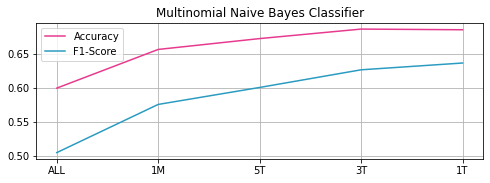

In [ ]:
draw_result('Multinomial Naive Bayes Classifier', NB_accuracy_result, NB_f1_weight_result)

### **2-2. 컴플리먼트 나이브 베이즈 (Complement Naive Bayes Classifier / CNB)**

In [ ]:
CNB_accuracy, CNB_f1_weight =  ml_model_train(ComplementNB(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(CNB_accuracy, CNB_f1_weight, "컴플리먼트 나이브 베이즈: 전체 num_words 사용")

CNB_1M_accuracy, CNB_1M_f1_weight =  ml_model_train(ComplementNB(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(CNB_1M_accuracy, CNB_1M_f1_weight, "컴플리먼트 나이브 베이즈: 10,000개의 num_words 사용")

CNB_5T_accuracy, CNB_5T_f1_weight =  ml_model_train(ComplementNB(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(CNB_5T_accuracy, CNB_5T_f1_weight, "컴플리먼트 나이브 베이즈: 5,000개의 num_words 사용")

CNB_3T_accuracy, CNB_3T_f1_weight =  ml_model_train(ComplementNB(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(CNB_3T_accuracy, CNB_3T_f1_weight, "컴플리먼트 나이브 베이즈: 3,000개의 num_words 사용")

CNB_1T_accuracy, CNB_1T_f1_weight =  ml_model_train(ComplementNB(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(CNB_1T_accuracy, CNB_1T_f1_weight, "컴플리먼트 나이브 베이즈: 1,000개의 num_words 사용")

<컴플리먼트 나이브 베이즈: 전체 num_words 사용>

Accuracy: 0.765
F1-Score: 0.735
------------------------------------------------------------
<컴플리먼트 나이브 베이즈: 10,000개의 num_words 사용>

Accuracy: 0.771
F1-Score: 0.746
------------------------------------------------------------
<컴플리먼트 나이브 베이즈: 5,000개의 num_words 사용>

Accuracy: 0.771
F1-Score: 0.746
------------------------------------------------------------
<컴플리먼트 나이브 베이즈: 3,000개의 num_words 사용>

Accuracy: 0.764
F1-Score: 0.737
------------------------------------------------------------
<컴플리먼트 나이브 베이즈: 1,000개의 num_words 사용>

Accuracy: 0.735
F1-Score: 0.697
------------------------------------------------------------


In [ ]:
CNB_accuracy_result = [0.765, 0.771, 0.771, 0.764, 0.735]
CNB_f1_weight_result = [0.735, 0.746, 0.746, 0.737, 0.697]

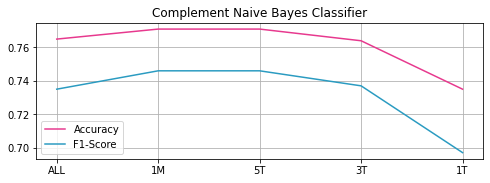

In [ ]:
draw_result('Complement Naive Bayes Classifier', CNB_accuracy_result, CNB_f1_weight_result)

### **2-3. 로지스틱 회귀 (Logistic Regression)**

In [ ]:
def LR_model():
    return LogisticRegression(C = 10000, penalty = 'l2', max_iter = 5000)

In [ ]:
LR_accuracy, LR_f1_weight =  ml_model_train(LR_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(LR_accuracy, LR_f1_weight, "로지스틱 회귀: 전체 num_words 사용")

LR_1M_accuracy, LR_1M_f1_weight =  ml_model_train(LR_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(LR_1M_accuracy, LR_1M_f1_weight, "로지스틱 회귀: 10,000개의 num_words 사용")

LR_5T_accuracy, LR_5T_f1_weight =  ml_model_train(LR_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(LR_5T_accuracy, LR_5T_f1_weight, "로지스틱 회귀: 5,000개의 num_words 사용")

LR_3T_accuracy, LR_3T_f1_weight =  ml_model_train(LR_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(LR_3T_accuracy, LR_3T_f1_weight, "로지스틱 회귀: 3,000개의 num_words 사용")

LR_1T_accuracy, LR_1T_f1_weight =  ml_model_train(LR_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(LR_1T_accuracy, LR_1T_f1_weight, "로지스틱 회귀: 1,000개의 num_words 사용")

<로지스틱 회귀: 전체 num_words 사용>

Accuracy: 0.817
F1-Score: 0.812
------------------------------------------------------------
<로지스틱 회귀: 10,000개의 num_words 사용>

Accuracy: 0.811
F1-Score: 0.806
------------------------------------------------------------
<로지스틱 회귀: 5,000개의 num_words 사용>

Accuracy: 0.803
F1-Score: 0.798
------------------------------------------------------------
<로지스틱 회귀: 3,000개의 num_words 사용>

Accuracy: 0.788
F1-Score: 0.784
------------------------------------------------------------
<로지스틱 회귀: 1,000개의 num_words 사용>

Accuracy: 0.739
F1-Score: 0.733
------------------------------------------------------------


In [ ]:
LR_accuracy_result = [0.817, 0.811, 0.803, 0.788, 0.739]
LR_f1_weight_result = [0.812, 0.806, 0.798, 0.784, 0.733]

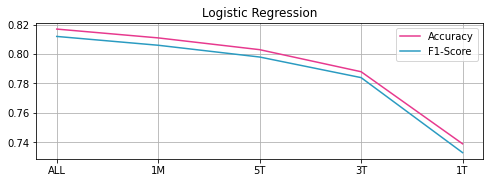

In [ ]:
draw_result('Logistic Regression', LR_accuracy_result, LR_f1_weight_result)

### **2-4. 선형 서포트 벡터 머신 (Linear Support Vector Machine)**

In [ ]:
def SVM_model():
    return LinearSVC(C = 1000, penalty = 'l1', max_iter = 5000, dual = False)

In [ ]:
SVM_accuracy, SVM_f1_weight =  ml_model_train(SVM_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(SVM_accuracy, SVM_f1_weight, "선형 서포트 벡터 머신: 전체 num_words 사용")

SVM_1M_accuracy, SVM_1M_f1_weight =  ml_model_train(SVM_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(SVM_1M_accuracy, SVM_1M_f1_weight, "선형 서포트 벡터 머신: 10,000개의 num_words 사용")

SVM_5T_accuracy, SVM_5T_f1_weight =  ml_model_train(SVM_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(SVM_5T_accuracy, SVM_5T_f1_weight, "선형 서포트 벡터 머신: 5,000개의 num_words 사용")

SVM_3T_accuracy, SVM_3T_f1_weight =  ml_model_train(SVM_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(SVM_3T_accuracy, SVM_3T_f1_weight, "선형 서포트 벡터 머신: 3,000개의 num_words 사용")

SVM_1T_accuracy, SVM_1T_f1_weight =  ml_model_train(SVM_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(SVM_1T_accuracy, SVM_1T_f1_weight, "선형 서포트 벡터 머신: 1,000개의 num_words 사용")

<선형 서포트 벡터 머신: 전체 num_words 사용>

Accuracy: 0.793
F1-Score: 0.789
------------------------------------------------------------
<선형 서포트 벡터 머신: 10,000개의 num_words 사용>

Accuracy: 0.783
F1-Score: 0.779
------------------------------------------------------------
<선형 서포트 벡터 머신: 5,000개의 num_words 사용>

Accuracy: 0.766
F1-Score: 0.763
------------------------------------------------------------
<선형 서포트 벡터 머신: 3,000개의 num_words 사용>

Accuracy: 0.756
F1-Score: 0.754
------------------------------------------------------------
<선형 서포트 벡터 머신: 1,000개의 num_words 사용>

Accuracy: 0.722
F1-Score: 0.718
------------------------------------------------------------


In [ ]:
SVM_accuracy_result = [0.793, 0.783, 0.766, 0.756, 0.722]
SVM_f1_weight_result = [0.789, 0.779, 0.763, 0.754, 0.718]

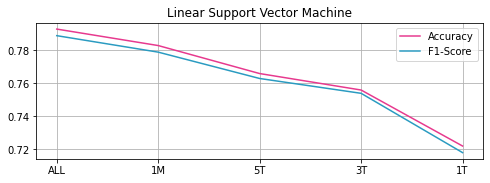

In [ ]:
draw_result('Linear Support Vector Machine', SVM_accuracy_result, SVM_f1_weight_result)

### **2-5. 결정 트리 (Decision Tree)**

In [ ]:
def DT_model():
    return DecisionTreeClassifier(max_depth = 10, random_state = 0)

In [ ]:
DT_accuracy, DT_f1_weight =  ml_model_train(DT_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(DT_accuracy, DT_f1_weight, "결정 트리: 전체 num_words 사용")

DT_1M_accuracy, DT_1M_f1_weight =  ml_model_train(DT_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(DT_1M_accuracy, DT_1M_f1_weight, "결정 트리: 10,000개의 num_words 사용")

DT_5T_accuracy, DT_5T_f1_weight =  ml_model_train(DT_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(DT_5T_accuracy, DT_5T_f1_weight, "결정 트리: 5,000개의 num_words 사용")

DT_3T_accuracy, DT_3T_f1_weight =  ml_model_train(DT_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(DT_3T_accuracy, DT_3T_f1_weight, "결정 트리: 3,000개의 num_words 사용")

DT_1T_accuracy, DT_1T_f1_weight =  ml_model_train(DT_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(DT_1T_accuracy, DT_1T_f1_weight, "결정 트리: 1,000개의 num_words 사용")

<결정 트리: 전체 num_words 사용>

Accuracy: 0.621
F1-Score: 0.577
------------------------------------------------------------
<결정 트리: 10,000개의 num_words 사용>

Accuracy: 0.62
F1-Score: 0.578
------------------------------------------------------------
<결정 트리: 5,000개의 num_words 사용>

Accuracy: 0.618
F1-Score: 0.573
------------------------------------------------------------
<결정 트리: 3,000개의 num_words 사용>

Accuracy: 0.626
F1-Score: 0.58
------------------------------------------------------------
<결정 트리: 1,000개의 num_words 사용>

Accuracy: 0.618
F1-Score: 0.545
------------------------------------------------------------


In [ ]:
DT_accuracy_result = [0.621, 0.620, 0.618, 0.626, 0.618]
DT_f1_weight_result = [0.577, 0.578, 0.573, 0.580, 0.545]

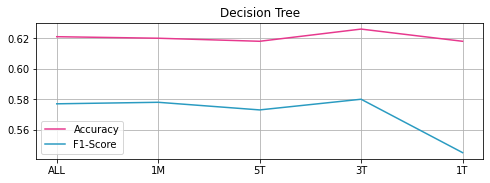

In [ ]:
draw_result('Decision Tree', DT_accuracy_result, DT_f1_weight_result)

### **2-6. 랜덤 포레스트 (Random Forest)**

In [ ]:
def RF_model():
    return RandomForestClassifier(n_estimators = 5, random_state = 0)

In [ ]:
RF_accuracy, RF_f1_weight =  ml_model_train(RF_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(RF_accuracy, RF_f1_weight, "랜덤 포레스트: 전체 num_words 사용")

RF_1M_accuracy, RF_1M_f1_weight =  ml_model_train(RF_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(RF_1M_accuracy, RF_1M_f1_weight, "랜덤 포레스트: 10,000개의 num_words 사용")

RF_5T_accuracy, RF_5T_f1_weight =  ml_model_train(RF_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(RF_5T_accuracy, RF_5T_f1_weight, "랜덤 포레스트: 5,000개의 num_words 사용")

RF_3T_accuracy, RF_3T_f1_weight =  ml_model_train(RF_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(RF_3T_accuracy, RF_3T_f1_weight, "랜덤 포레스트: 3,000개의 num_words 사용")

RF_1T_accuracy, RF_1T_f1_weight =  ml_model_train(RF_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(RF_1T_accuracy, RF_1T_f1_weight, "랜덤 포레스트: 1,000개의 num_words 사용")

<랜덤 포레스트: 전체 num_words 사용>

Accuracy: 0.654
F1-Score: 0.623
------------------------------------------------------------
<랜덤 포레스트: 10,000개의 num_words 사용>

Accuracy: 0.674
F1-Score: 0.643
------------------------------------------------------------
<랜덤 포레스트: 5,000개의 num_words 사용>

Accuracy: 0.701
F1-Score: 0.677
------------------------------------------------------------
<랜덤 포레스트: 3,000개의 num_words 사용>

Accuracy: 0.686
F1-Score: 0.659
------------------------------------------------------------
<랜덤 포레스트: 1,000개의 num_words 사용>

Accuracy: 0.707
F1-Score: 0.683
------------------------------------------------------------


In [ ]:
RF_accuracy_result = [0.654, 0.674, 0.701, 0.686, 0.707]
RF_f1_weight_result = [0.623, 0.643, 0.677, 0.659, 0.683]

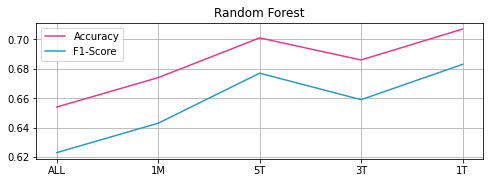

In [ ]:
draw_result('Random Forest', RF_accuracy_result, RF_f1_weight_result)

### **2-7. 그래디언트 부스팅 트리 (GradientBoostingClassifier)**

In [ ]:
def GBC_model():
    return GradientBoostingClassifier(random_state = 0, learning_rate = 0.01)

In [ ]:
GBC_accuracy, GBC_f1_weight =  ml_model_train(GBC_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(GBC_accuracy, GBC_f1_weight, "그래디언트 부스팅 트리: 전체 num_words 사용")

GBC_1M_accuracy, GBC_1M_f1_weight =  ml_model_train(GBC_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(GBC_1M_accuracy, GBC_1M_f1_weight, "그래디언트 부스팅 트리: 10,000개의 num_words 사용")

GBC_5T_accuracy, GBC_5T_f1_weight =  ml_model_train(GBC_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(GBC_5T_accuracy, GBC_5T_f1_weight, "그래디언트 부스팅 트리: 5,000개의 num_words 사용")

GBC_3T_accuracy, GBC_3T_f1_weight =  ml_model_train(GBC_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(GBC_3T_accuracy, GBC_3T_f1_weight, "그래디언트 부스팅 트리: 3,000개의 num_words 사용")

GBC_1T_accuracy, GBC_1T_f1_weight =  ml_model_train(GBC_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(GBC_1T_accuracy, GBC_1T_f1_weight, "그래디언트 부스팅 트리: 1,000개의 num_words 사용")

<그래디언트 부스팅 트리: 전체 num_words 사용>

Accuracy: 0.762
F1-Score: 0.748
------------------------------------------------------------
<그래디언트 부스팅 트리: 10,000개의 num_words 사용>

Accuracy: 0.757
F1-Score: 0.744
------------------------------------------------------------
<그래디언트 부스팅 트리: 5,000개의 num_words 사용>

Accuracy: 0.762
F1-Score: 0.749
------------------------------------------------------------
<그래디언트 부스팅 트리: 3,000개의 num_words 사용>

Accuracy: 0.756
F1-Score: 0.741
------------------------------------------------------------
<그래디언트 부스팅 트리: 1,000개의 num_words 사용>

Accuracy: 0.742
F1-Score: 0.719
------------------------------------------------------------


In [ ]:
GBC_accuracy_result = [0.762, 0.757, 0.762, 0.756, 0.742]
GBC_f1_weight_result = [0.748, 0.744, 0.749, 0.741, 0.719]

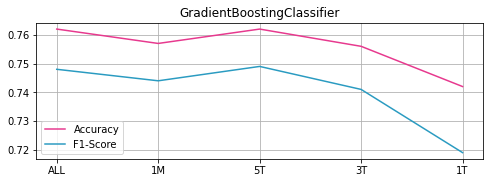

In [ ]:
draw_result('GradientBoostingClassifier', GBC_accuracy_result, GBC_f1_weight_result)

### **2-8. 보팅 (Voting)**

In [ ]:
def voting_model():
    voting_classifier = VotingClassifier(estimators=[('lr', LogisticRegression(C = 10000, penalty = 'l2')),('cb', ComplementNB())], voting = 'soft', n_jobs =- 1)
    return voting_classifier

In [ ]:
voting_accuracy, voting_f1_weight =  ml_model_train(voting_model(), vector_x_train, y_train, vector_x_test, y_test)
ml_model_result(voting_accuracy, voting_f1_weight, "보팅: 전체 num_words 사용")

voting_1M_accuracy, voting_1M_f1_weight =  ml_model_train(voting_model(), vector_x_train_1M, y_train, vector_x_test_1M, y_test)
ml_model_result(voting_1M_accuracy, voting_1M_f1_weight, "보팅: 10,000개의 num_words 사용")

voting_5T_accuracy, voting_5T_f1_weight =  ml_model_train(voting_model(), vector_x_train_5T, y_train, vector_x_test_5T, y_test)
ml_model_result(voting_5T_accuracy, voting_5T_f1_weight, "보팅: 5,000개의 num_words 사용")

voting_3T_accuracy, voting_3T_f1_weight =  ml_model_train(voting_model(), vector_x_train_3T, y_train, vector_x_test_3T, y_test)
ml_model_result(voting_3T_accuracy, voting_3T_f1_weight, "보팅: 3,000개의 num_words 사용")

voting_1T_accuracy, voting_1T_f1_weight =  ml_model_train(voting_model(), vector_x_train_1T, y_train, vector_x_test_1T, y_test)
ml_model_result(voting_1T_accuracy, voting_1T_f1_weight, "보팅: 1,000개의 num_words 사용")

<보팅: 전체 num_words 사용>

Accuracy: 0.816
F1-Score: 0.81
------------------------------------------------------------
<보팅: 10,000개의 num_words 사용>

Accuracy: 0.811
F1-Score: 0.805
------------------------------------------------------------
<보팅: 5,000개의 num_words 사용>

Accuracy: 0.809
F1-Score: 0.803
------------------------------------------------------------
<보팅: 3,000개의 num_words 사용>

Accuracy: 0.801
F1-Score: 0.795
------------------------------------------------------------
<보팅: 1,000개의 num_words 사용>

Accuracy: 0.784
F1-Score: 0.777
------------------------------------------------------------


In [ ]:
Voting_accuracy_result = [0.816, 0.811, 0.809, 0.801, 0.784]
Voting_f1_weight_result = [0.81, 0.805, 0.803, 0.795, 0.777]

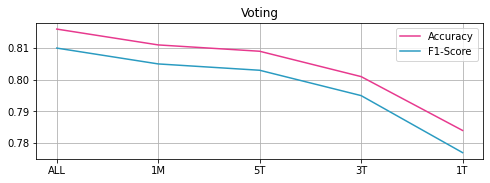

In [ ]:
draw_result('Voting', Voting_accuracy_result, Voting_f1_weight_result)

## **3. 딥러닝 모델을 사용한 학습 및 성능 확인**

- **데이터 전처리**

In [ ]:
def dnn_data(x_train, y_train, x_test, y_test):
    max_len = 300

    _x_train = pad_sequences(x_train, maxlen = max_len, padding = "pre")
    _x_test = pad_sequences(x_test, maxlen = max_len, padding = "pre")

    _y_train = to_categorical(y_train)
    _y_test = to_categorical(y_test)

    partial_x_train, x_val, partial_y_train, y_val = train_test_split(_x_train, _y_train, test_size = 0.2, random_state = 2525)
    return (partial_x_train, partial_y_train, x_val, y_val, _x_test, _y_test)

In [ ]:
DL = dnn_data(x_train, y_train, x_test, y_test)
DL_1M = dnn_data(x_train_1M, y_train_1M, x_test_1M, y_test_1M)
DL_5T = dnn_data(x_train_5T, y_train_5T, x_test_5T, y_test_5T)
DL_3T = dnn_data(x_train_3T, y_train_3T, x_test_3T, y_test_3T)
DL_1T = dnn_data(x_train_1T, y_train_1T, x_test_1T, y_test_1T)

- **모델 생성**

In [ ]:
def get_dnn(vocab_size):
    word_vector_dim = 128

    model_1d = tf.keras.Sequential()
    model_1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
    model_1d.add(tf.keras.layers.Conv1D(256, 32, activation='gelu'))
    model_1d.add(tf.keras.layers.MaxPooling1D(4))
    model_1d.add(tf.keras.layers.Dropout(0.3))

    model_1d.add(tf.keras.layers.Conv1D(256, 32, activation='gelu'))
    model_1d.add(tf.keras.layers.GlobalMaxPooling1D())
    model_1d.add(tf.keras.layers.Dropout(0.3))

    model_1d.add(tf.keras.layers.Dense(46, activation='softmax'))
    
    model_1d.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', f1_m])    
    
    model_1d.summary()
    return model_1d

- **F1 계산**

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

- **모델 학습**

In [ ]:
def train_model(model, data):
    x_train, y_train, x_val, y_val = data[0], data[1], data[2], data[3]
    x_test, y_test = data[4], data[5]
    
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
    history = model.fit(x_train, y_train, epochs = 30, batch_size = 64, verbose = 1, validation_data = (x_val, y_val), callbacks = es)
    
    test_data = model.evaluate(x_test, y_test)

    print('\n\n\n<학습 결과>')
    print('Loss:', round(test_data[0], 3))
    print('Accuracy:', round(test_data[1], 3))
    print('F1-Score:', round(test_data[2], 3))
    return history

In [ ]:
model = get_dnn(30982)
train_model(model, DL)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         3965696   
                                                                 
 conv1d_10 (Conv1D)          (None, None, 256)         1048832   
                                                                 
 max_pooling1d_5 (MaxPooling  (None, None, 256)        0         
 1D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, None, 256)         0         
                                                                 
 conv1d_11 (Conv1D)          (None, None, 256)         2097408   
                                                                 
 global_max_pooling1d_5 (Glo  (None, 256)              0         
 balMaxPooling1D)                                     

In [ ]:
model = get_dnn(10000)
train_model(model, DL_1M)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 128)         1280000   
                                                                 
 conv1d_12 (Conv1D)          (None, None, 256)         1048832   
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 256)        0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, None, 256)         0         
                                                                 
 conv1d_13 (Conv1D)          (None, None, 256)         2097408   
                                                                 
 global_max_pooling1d_6 (Glo  (None, 256)              0         
 balMaxPooling1D)                                     

In [ ]:
model = get_dnn(5000)
train_model(model, DL_5T)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 128)         640000    
                                                                 
 conv1d_14 (Conv1D)          (None, None, 256)         1048832   
                                                                 
 max_pooling1d_7 (MaxPooling  (None, None, 256)        0         
 1D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, None, 256)         0         
                                                                 
 conv1d_15 (Conv1D)          (None, None, 256)         2097408   
                                                                 
 global_max_pooling1d_7 (Glo  (None, 256)              0         
 balMaxPooling1D)                                     

In [ ]:
model = get_dnn(3000)
train_model(model, DL_3T)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 128)         384000    
                                                                 
 conv1d_16 (Conv1D)          (None, None, 256)         1048832   
                                                                 
 max_pooling1d_8 (MaxPooling  (None, None, 256)        0         
 1D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, None, 256)         0         
                                                                 
 conv1d_17 (Conv1D)          (None, None, 256)         2097408   
                                                                 
 global_max_pooling1d_8 (Glo  (None, 256)              0         
 balMaxPooling1D)                                     

In [ ]:
model = get_dnn(1000)
train_model(model, DL_1T)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 128)         128000    
                                                                 
 conv1d_18 (Conv1D)          (None, None, 256)         1048832   
                                                                 
 max_pooling1d_9 (MaxPooling  (None, None, 256)        0         
 1D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, None, 256)         0         
                                                                 
 conv1d_19 (Conv1D)          (None, None, 256)         2097408   
                                                                 
 global_max_pooling1d_9 (Glo  (None, 256)              0         
 balMaxPooling1D)                                     

In [ ]:
DNN_accuracy_result = [0.758, 0.772, 0.770, 0.749, 0.754]
DNN_f1_weight_result = [0.765, 0.780, 0.779, 0.762, 0.771]

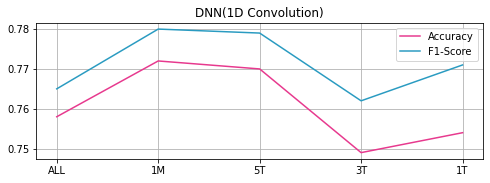

In [ ]:
draw_result('DNN(1D Convolution)', DNN_accuracy_result, DNN_f1_weight_result)

## **4. 전체 학습 결과 비교**

### **4-1. 전체 학습 결과의 Accuracy 비교**

In [ ]:
def draw_all_result(title, NB, CNB, LR, SVM, DT, RF, GBC, Voting, DNN):
    plt.figure(figsize = (8, 5))
    plt.grid(True)
    plt.title(f'{title}')
    plt.plot(label_num, NB, color = '#78DB39', label = 'Multinomial Naive Bayes Classifier')
    plt.plot(label_num, CNB, color = '#00FFFF', label = 'Complement Naive Bayes Classifier')
    plt.plot(label_num, LR, color = '#FFCC33', label = 'Logistic Regression')
    plt.plot(label_num, SVM, color = '#5E38C1', label = 'Linear Support Vector Machine')
    plt.plot(label_num, DT, color = '#FC8B27', label = 'Decision Tree')
    plt.plot(label_num, RF, color = '#E7398E', label = 'Random Forest')
    plt.plot(label_num, GBC, color = '#2A9BC1', label = 'GradientBoostingClassifier')
    plt.plot(label_num, Voting, color = '#B918C6', label = 'Voting')
    plt.plot(label_num, DNN, color = '#FF4040', label = '1D Convolution')
    plt.legend(bbox_to_anchor = (1, 1))
    plt.show()

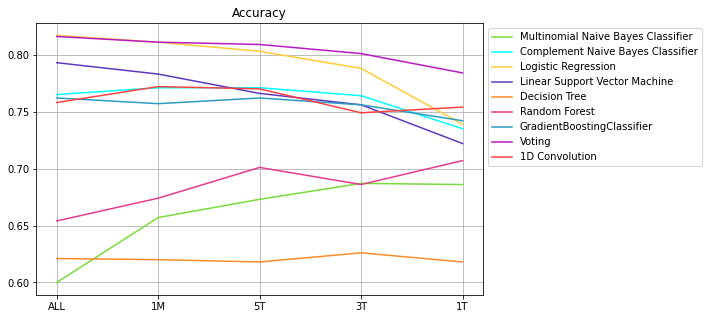

In [ ]:
draw_all_result('Accuracy', NB_accuracy_result, CNB_accuracy_result, LR_accuracy_result, SVM_accuracy_result, 
                DT_accuracy_result, RF_accuracy_result, GBC_accuracy_result, Voting_accuracy_result, DNN_accuracy_result)

### **4-2. 전체 학습 결과의 F1-Score 비교**

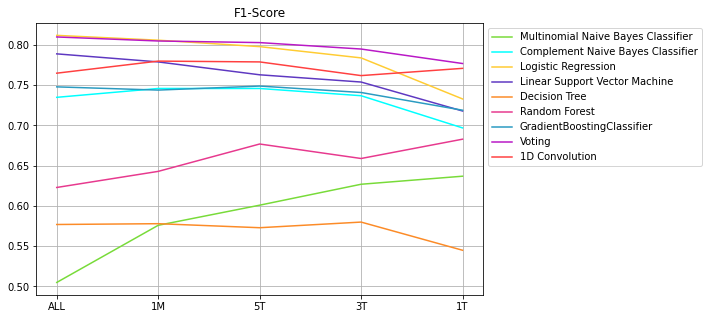

In [ ]:
draw_all_result('F1-Score', NB_f1_weight_result, CNB_f1_weight_result, LR_f1_weight_result, SVM_f1_weight_result, 
                DT_f1_weight_result, RF_f1_weight_result, GBC_f1_weight_result, Voting_f1_weight_result, DNN_f1_weight_result)

### **4-3. Vocabulary Size에 따른 개별 모델 성능 비교 분석**

|**Model**|**Accuracy** *(All/10,000/5,000/3,000/1,000)*|**F1-Score** *(All/10,000/5,000/3,000/1,000)*|**Review**|
|:---:|:---:|:---:|:---:|
|**Multinomial Naive Bayes Classifier**|0.600 / 0.657 / 0.673 / 0.687 / 0.686|0.505 / 0.576 / 0.601 / 0.627 / 0.637|대체적으로 Vocabulary Size가 작을수록 좋은 성능을 보임|
|**Complement Naive Bayes Classifier**|0.765 / 0.771 / 0.771 / 0.764 / 0.735|0.735 / 0.746 / 0.746 / 0.737 / 0.697|5,000개의 Vocabulary 까지는 Size가 작은 경우 성능이 점점 좋아지나 3,000개의 Vocabulary부터는 오히려 성능이 떨어지는 모습을 보임|
|**Logistic Regression**|0.817 / 0.811 / 0.803 / 0.788 / 0.739|0.812 / 0.806 / 0.798 / 0.784 / 0.733|대체적으로 Vocabulary Size가 클수록 좋은 성능을 보임|
|**Linear Support Vector Machine**|0.793 / 0.783 / 0.766 / 0.756 / 0.722|0.789 / 0.779 / 0.763 / 0.754 / 0.718|대체적으로 Vocabulary Size가 클수록 좋은 성능을 보임|
|**Decision Tree**|0.621 / 0.620 / 0.618 / 0.626 / 0.618|0.577 / 0.578 / 0.573 / 0.580 / 0.545|대체적으로 Vocabulary Size와 상관 없이 비슷한 성능을 보이나 Vocabulary Size가 1,000일 경우 성능이 급격히 낮아지는 모습을 보임|
|**Random Forest**|0.654 / 0.674 / 0.701 / 0.686 / 0.707|0.623 / 0.643 / 0.677 / 0.659 / 0.683|5,000개의 Vocabulary 까지는 Size가 작은 경우 성능이 점점 좋아지나 3,000개의 Vocabulary부터는 성능이 일정하지 않은 모습을 보임|
|**GradientBoostingClassifier**|0.762 / 0.757 / 0.762 / 0.756 / 0.742|0.748 / 0.744 / 0.749 / 0.741 / 0.719|Vocabulary Size에 상관없이 성능이 일정하지 않은 모습을 보임|
|**Voting**|0.816 / 0.811 / 0.809 / 0.801 / 0.784|0.810  / 0.805 / 0.803 / 0.795 / 0.777|대체적으로 Vocabulary Size가 클수록 좋은 성능을 보임|
|**1D Convolution**|0.758 / 0.772 / 0.770 / 0.749 / 0.754|0.765 / 0.780 / 0.779 / 0.762 / 0.771|Vocabulary Size에 상관없이 성능이 일정하지 않은 모습을 보임|

### **4-4. 평균 성능에 따른 전체 모델 성능 비교 분석**

|**Model**|**Accuracy Average**|**F1-Score Average**|**Accuracy Rank**|**F1-Score Rank**|**Review**|  
|:---:|:---:|:---:|:---:|:---:|:---:|
|**Multinomial Naive Bayes Classifier**|0.660|0.589|8th|8th|불균형 데이터 사용으로 가중치가 한쪽으로 쏠려 특정 클래스를 선호하는 현상이 발생해 0.68정도의 두번째로 낮은 성능을 보임|
|**Complement Naive Bayes Classifier**|0.761|0.732|4th|6th|나이브 베이즈 분류기의 단점을 보완한 모델로, 데이터의 불균형을 고려해 가중치를 부여하므로 나이브 베이즈 분류기에 비해 0.12 이상의 좋은 성능을 보임|  
|**Logistic Regression**|0.791|0.786|2nd|2nd|소프트맥스 함수를 사용한 다중 클래스 분류로 0.78 정도의 두번째로 높은 성능을 보임|  
|**Linear Support Vector Machine**|0.764|0.760|3rd|4th|가장 높은 점수를 내는 이진 분류기의 클래스를 예측값으로 선택하므로 0.76 정도의 높은 성능을 보임|  
|**Decision Tree**|0.620|0.570|**9th**|**9th**|DTM, TF-IDF 행렬의 경우 고차원이면서 대부분의 값이 0으로 이루어진 희소 데이터이므로 0.58 정도의 가장 낮은 성능을 보임|  
|**Random Forest**|0.684|0.657|7th|7th|다른 방향으로 과적합된 트리들을 조합해 과적합을 피하는 모델이나 0.68 정도로 그저 그런 성능을 보임|  
|**GradientBoostingClassifier**|0.755|0.740|4th|5th|일반적으로 깊지 않은 트리를 사용해 메모리도 작고 예측도 빠르면서 0.7 이상의 높은 성능을 보임|  
|**Voting**|0.804|0.798|**1st**|**1st**|투표를 통해 가장 좋은 결과를 선택해 도출하는 모델로 0.79 정도의 가장 높은 성능을 보임|  
|**1D Convolution**|0.760|0.771|4th|3rd|1D Convolution 딥러닝 모델의 경우 0.771 정도의 성능을 보이므로 준수한 성능을 가진 머신러닝 모델에 뒤쳐지지 않는 것을 확인 가능|  

---